In [1]:
# general libs
import os 
import gdown
import matplotlib.pyplot as plt
import logging
import numpy as np 
import pandas as pd
import random
import shutil
import nvidia_smi
import socket
import wandb

from PIL import Image
from glob import glob
from timeit import default_timer as timer
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
# torch libs
import torch
import torchvision

from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# current directory
current_dir = os.getcwd()

# current directory name
current_dir_name = os.path.basename(current_dir)

# datetime info
now_str = datetime.now().strftime("%a, %d %b %Y %H:%M:%S")
date_str = datetime.now().strftime("%Y%m%d")
datetime_str = datetime.now().strftime("%Y%m%d_%H%M%S")

# model name
model_name = "efficientnet_b0"

# batch size
batch_size = 16

# data directory
DATA_DIR = Path('../../data/')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# project name
project_name = f"{current_dir_name}/06_transfer_learning_{date_str}/{model_name}_bs_{batch_size}"

# log directory
LOG_DIR = Path(f'../../logs/{project_name}')
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir(parents=True, exist_ok=True)
else:
    os.system(f"rm -rf {LOG_DIR}")
    LOG_DIR.mkdir(parents=True, exist_ok=True)

# file_name
file_name = f"{model_name}_bs_{batch_size}_{datetime_str}"
    
LOG_FILE_PATH = LOG_DIR.joinpath(f"06_transfer_learning_{file_name}.log")
FE_HISTORY_CURVES_FILE_PATH = LOG_DIR.joinpath(f"fe_history_curves_{file_name}.png")
FT_HISTORY_CURVES_FILE_PATH = LOG_DIR.joinpath(f"ft_history_curves_{file_name}.png")
FE_PREDICTION_FILE_PATH = LOG_DIR.joinpath(f"fe_prediction_{file_name}.png")
FT_PREDICTION_FILE_PATH = LOG_DIR.joinpath(f"ft_prediction_{file_name}.png")

# model directory
MODEL_DIR = Path(f'../../models/{project_name}')
if not MODEL_DIR.is_dir():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
else:
    os.system(f"rm -rf {MODEL_DIR}")
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

FE_MODEL_FILE_PATH = MODEL_DIR.joinpath(f"fe_{file_name}.h5")
FT_MODEL_FILE_PATH = MODEL_DIR.joinpath(f"ft_{file_name}.h5")

# logging configuration
logging.basicConfig(
    level=logging.INFO,
    datefmt="%a, %d %b %Y %H:%M:%S",
    format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename=LOG_FILE_PATH, mode="w"),
        logging.StreamHandler()
    ]
)

# created date
logging.info(f"Created date: Tue, 12 Sep 2023 10:22:52")

# modified date
logging.info(f"Modified date: {now_str}")

# project info
# logging.info(f"Current directory: {current_dir}")
logging.info(f"Current directory's name: {current_dir_name}")
logging.info(f"Project name: {project_name}")

# model name
logging.info(f"Model name: {model_name}")

# torch version
logging.info(f"Torch version: {torch.__version__}")
logging.info(f"Torchvision version: {torchvision.__version__}")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Device: {device}")

# gpus
num_gpus = torch.cuda.device_count()
logging.info(f"GPUs: {num_gpus}")

# cuda version
cuda_version = torch.version.cuda
logging.info(f"Cuda version: {cuda_version}")

# cpus
num_cpus = os.cpu_count()
logging.info(f"CPUs: {num_cpus}")

# speed up training
use_data_parallel = True
is_running_data_parallel = False
logging.info(f"Use DataParallel: {use_data_parallel}")

# batch size
logging.info(f"Batch size: {batch_size}")


# default seed
default_seed = 42
logging.info(f"Default seed: {default_seed}")

# dropout_rate
dropout_rate = 0.5
logging.info(f"Using dropout_rate: {dropout_rate}")

# set seed
logging.info(f"Set default seed for torch.manual_seed({default_seed}) and torch.cuda.manual_seed({default_seed})") 
os.environ["PYTHONHASHSEED"] = str(default_seed)
random.seed(default_seed)
np.random.seed(default_seed)
torch.manual_seed(default_seed)
torch.cuda.manual_seed(default_seed)
torch.cuda.manual_seed_all(default_seed)
torch.backends.cudnn.benchmark = True # find the best algorithms for this 
torch.backends.cudnn.deterministic = True # for reproducible purpose

## Downloading datasets from urls
# 10 percents dataset
DATASET_10_PERCENT_URL = "https://drive.google.com/uc?id=17Yw1PGyDGpwV77Ds6VDBQ7Iv9Q2rQR6P"
DATASET_10_PERCENT_ZIPFILE_NAME = "10_food_classes_10_percent.zip"
DATASET_10_PERCENT_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_10_PERCENT_ZIPFILE_NAME)
DATASET_10_PERCENT_FOLDER_NAME = "10_food_classes_10_percent"
DATASET_10_PERCENT_FOLDER_PATH = DATA_DIR.joinpath(DATASET_10_PERCENT_FOLDER_NAME)

# full data dataset
DATASET_FULL_DATA_URL = "https://drive.google.com/uc?id=1h9Zvm0UKeGMk8hXSdfCJ5E1hIgxvQHN6"
DATASET_FULL_DATA_ZIPFILE_NAME = "food10.zip"
DATASET_FULL_DATA_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_FULL_DATA_ZIPFILE_NAME)
DATASET_FULL_DATA_FOLDER_NAME = "food10"
DATASET_FULL_DATA_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FULL_DATA_FOLDER_NAME)

# download 10 percents dataset
if not DATASET_10_PERCENT_ZIPFILE_PATH.is_file():
    logging.info(f"The `{DATASET_10_PERCENT_ZIPFILE_NAME}` is downloading...")
    try:
        gdown.download(url=DATASET_10_PERCENT_URL, output=str(DATASET_10_PERCENT_ZIPFILE_PATH))
        logging.info(f"The `{DATASET_10_PERCENT_ZIPFILE_NAME}` is downloaded successfully.")
    except Exception as error:
        logging.info(f"Caught this error during downloading {DATASET_10_PERCENT_ZIPFILE_NAME}")
else:
    logging.info(f"The `{DATASET_10_PERCENT_ZIPFILE_NAME}` already exists.")

# extract 10 percents dataset
if not DATASET_10_PERCENT_FOLDER_PATH.is_dir():
    logging.info(f"The `{DATASET_10_PERCENT_ZIPFILE_NAME}` is extracting...")
    try:
        gdown.extractall(path=str(DATASET_10_PERCENT_ZIPFILE_PATH), to=str(DATA_DIR))
        logging.info(f"The `{DATASET_10_PERCENT_ZIPFILE_NAME}` is extracted successfully.")
    except Exception as error:
        logging.info(f"Caught this error during extracting `{DATASET_10_PERCENT_ZIPFILE_NAME}`")
else:
    logging.info(f"The `{DATASET_10_PERCENT_FOLDER_NAME}` already exists.")



# download full dataset
if not DATASET_FULL_DATA_ZIPFILE_PATH.is_file():
    logging.info(f"The {DATASET_FULL_DATA_ZIPFILE_NAME} is downloading...")
    try:
        gdown.download(url=DATASET_FULL_DATA_URL, output=str(DATASET_FULL_DATA_ZIPFILE_PATH))
        logging.info(f"The `{DATASET_FULL_DATA_ZIPFILE_NAME}` is downloaded successfully.")
    except Exception as error:
        logging.info(f"Caught this error during downloading `{DATASET_FULL_DATA_ZIPFILE_NAME}`")
else:
    logging.info(f"The `{DATASET_FULL_DATA_ZIPFILE_NAME}` already exists.")

# extract full dataset
if not DATASET_FULL_DATA_FOLDER_PATH.is_dir():
    logging.info(f"The `{DATASET_FULL_DATA_ZIPFILE_NAME}` is extracting...")
    try:
        gdown.extractall(path=str(DATASET_FULL_DATA_ZIPFILE_PATH), to=str(DATA_DIR))
        logging.info(f"The `{DATASET_FULL_DATA_ZIPFILE_NAME}` is extracted successfully.")
    except Exception as error:
        logging.info(f"Caught this error during extracting `{DATASET_FULL_DATA_ZIPFILE_NAME}`")
else:
    logging.info(f"The `{DATASET_FULL_DATA_FOLDER_NAME}` already exists.")


/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[Fri, 15 Sep 2023 17:21:56.353] INFO - Created date: Tue, 12 Sep 2023 10:22:52
[Fri, 15 Sep 2023 17:21:56.353] INFO - Modified date: Fri, 15 Sep 2023 17:21:56
[Fri, 15 Sep 2023 17:21:56.354] INFO - Current directory's name: practice
[Fri, 15 Sep 2023 17:21:56.354] INFO - Project name: practice/06_transfer_learning_20230915/efficientnet_b0_bs_16
[Fri, 15 Sep 2023 17:21:56.354] INFO - Model name: efficientnet_b0
[Fri, 15 Sep 2023 17:21:56.355] INFO - Torch version: 1.12.1+cu102
[Fri, 15 Sep 2023 17:21:56.355] INFO - Torchvision version: 0.13.1+cu102
[Fri, 15 Sep 2023 17:21:56.368] INFO - Device: cuda
[Fri, 15 Sep 2023 17:21:56.369] INFO - GPUs: 1
[Fri, 15 Sep 2023 17:21:56.369] INFO - Cuda version: 10.2
[Fri, 15 Sep 2023 17:21

In [2]:
def walkthough_data(data_directory: Path):
    total_images  = 0
    if data_directory.is_dir():
        for filepaths, dirnames, filenames in os.walk(data_directory):
            if len(filenames) > 0:
                total_images += len(filenames)
        
        logging.info(f"There are {total_images} images in the {data_directory}")
    else: 
        logging.info(f"There is no given directory.")


def split_validation_data(dataset_directory: Path, ratio: float= 0.1):
    
    if dataset_directory.is_dir():

        parent_directory = dataset_directory.parents[0]
        # print(f"parent_directory: {parent_directory}.")
        val_dir = parent_directory.joinpath("val")
        if not val_dir.is_dir():
            val_dir.mkdir(parents=True, exist_ok=True) 

            filepaths = glob(os.path.join(dataset_directory, "*/*.jpg"))
            total_files = len(filepaths)
            val_files = int(0.1 * total_files)

            logging.info(f"There are {total_files} images in {dataset_directory}.")
            logging.info(f"There will be {val_files} images for validation data.")

            random_val_filepaths = random.sample(filepaths, val_files)
            logging.info(f"Randomly selecting {len(random_val_filepaths)} from total {total_files} images in {dataset_directory}.")
            # print(f"Randomly selected files: {random_val_filepaths}")

            for random_val_filepath in random_val_filepaths:
                class_name = random_val_filepath.split("/")[-2]
                # print(f"class name: {class_name}")
                val_class_dir = val_dir.joinpath(class_name)
                if not val_class_dir.is_dir():
                    val_class_dir.mkdir(parents=True, exist_ok=True)

                shutil.move(random_val_filepath, val_class_dir)


        else:
            logging.info(f"The {val_dir} already exist.")     
            
    else:
        logging.info(f"There is no given directory like this {dataset_directory}.")

    return val_dir


def visualise_random_images(images_dir: Path, n: int = 10):

    if images_dir.is_dir():
        filepaths = glob(os.path.join(images_dir, "*/*.jpg"))
        randomly_selected_image_filepaths = random.sample(filepaths, n)
        print(f"Selected randomly {len(randomly_selected_image_filepaths)} images in {images_dir}")

        # display images
        plt.figure(figsize=(25, 10))
        for i, randomly_selected_image_filepath in enumerate(randomly_selected_image_filepaths):
            
            plt.subplot(2, len(randomly_selected_image_filepaths) // 2, i + 1)
            image = Image.open(randomly_selected_image_filepath)
            plt.imshow(image)
            plt.axis(False) 
            
    else:
        print(f"There is no given directory like this {images_dir}.")

In [3]:
## directories

# train 10 percent data
train_10_percent_dir = DATASET_10_PERCENT_FOLDER_PATH.joinpath("train")
walkthough_data(data_directory=train_10_percent_dir)

# test 10 percent data
test_10_percent_dir = DATASET_10_PERCENT_FOLDER_PATH.joinpath("test")
walkthough_data(data_directory=test_10_percent_dir)

# val 10 percent data
val_10_percent_dir = split_validation_data(dataset_directory=train_10_percent_dir)
walkthough_data(data_directory=val_10_percent_dir)


# train full data
train_full_data_dir = DATASET_FULL_DATA_FOLDER_PATH.joinpath("train")
walkthough_data(data_directory=train_full_data_dir)

# test full data
test_full_data_dir = DATASET_FULL_DATA_FOLDER_PATH.joinpath("test")
walkthough_data(data_directory=test_full_data_dir)

# val full data
val_full_data_dir = split_validation_data(dataset_directory=train_full_data_dir)
walkthough_data(data_directory=val_full_data_dir)

# visualise_random_images(images_dir=train_10_percent_dir)

[Fri, 15 Sep 2023 17:21:56.403] INFO - There are 675 images in the ../../data/10_food_classes_10_percent/train
[Fri, 15 Sep 2023 17:21:56.407] INFO - There are 2500 images in the ../../data/10_food_classes_10_percent/test
[Fri, 15 Sep 2023 17:21:56.408] INFO - The ../../data/10_food_classes_10_percent/val already exist.
[Fri, 15 Sep 2023 17:21:56.409] INFO - There are 75 images in the ../../data/10_food_classes_10_percent/val
[Fri, 15 Sep 2023 17:21:56.414] INFO - There are 6750 images in the ../../data/food10/train
[Fri, 15 Sep 2023 17:21:56.416] INFO - There are 2500 images in the ../../data/food10/test
[Fri, 15 Sep 2023 17:21:56.417] INFO - The ../../data/food10/val already exist.
[Fri, 15 Sep 2023 17:21:56.419] INFO - There are 750 images in the ../../data/food10/val


In [4]:
## DATA PREPROCESSING

# train transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.484, 0.465, 0.406], std=[0.229, 0.224, 0.225])
])

# test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.484, 0.465, 0.406], std=[0.229, 0.224, 0.225])
])

# val transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.484, 0.465, 0.406], std=[0.229, 0.224, 0.225])
])

## datasets
# train 10 percent dataset
train_10_percent_dataset = ImageFolder(root=train_10_percent_dir, transform= train_transform)

# test 10 percent dataset
test_10_percent_dataset = ImageFolder(root=test_10_percent_dir, transform= test_transform)

# val 10 percent dataset
val_10_percent_dataset = ImageFolder(root=val_10_percent_dir, transform= val_transform)

# train full dataset
train_full_dataset = ImageFolder(root=train_full_data_dir, transform= train_transform)

# test full dataset
test_full_dataset = ImageFolder(root=test_full_data_dir, transform= test_transform)

# val full dataset
val_full_dataset = ImageFolder(root=val_full_data_dir, transform= val_transform)

## dataloaders
# train 10 percent dataloader
train_10_percent_dataloader = DataLoader(dataset=train_10_percent_dataset,
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            num_workers=num_cpus)

# test 10 percent dataloader
test_10_percent_dataloader = DataLoader(dataset=test_10_percent_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False, 
                                            num_workers=num_cpus)

# val 10 percent dataloader
val_10_percent_dataloader = DataLoader(dataset=val_10_percent_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            num_workers=num_cpus)

# train full dataloader
train_full_data_dataloader = DataLoader(dataset=train_full_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            num_workers=num_cpus)

# test full dataloader
test_full_data_dataloader = DataLoader(dataset=test_full_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False, 
                                            num_workers=num_cpus)

# val full dataloader
val_full_data_dataloader = DataLoader(dataset=val_full_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            num_workers=num_cpus)

# class names
class_names = train_10_percent_dataset.classes
logging.info(f"Class names: {class_names}")
logging.info(f"len(class_names): {len(class_names)}")

[Fri, 15 Sep 2023 17:21:56.472] INFO - Class names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']
[Fri, 15 Sep 2023 17:21:56.472] INFO - len(class_names): 10


In [5]:
## Pretrained-weights

# efficientnet-b0's weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efficientnet_b0_model = torchvision.models.efficientnet_b0(weights=weights)

efficientnet_b0_model
# summary
# summary(model=efficientnet_b0_model, 
#         input_size=(32, 3, 224, 224), 
#         verbose=1)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
logging.info(summary(model=efficientnet_b0_model, 
        input_size=(32, 3, 224, 224), 
        verbose=1))

[Fri, 15 Sep 2023 17:21:59.374] INFO - =========================================================================================================
Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]         

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [7]:
def get_gpu_util():

    logging.info("GPU status")
    nvidia_smi.nvmlInit()
    deviceCount = nvidia_smi.nvmlDeviceGetCount()
    host_name = socket.gethostname()
    now = datetime.now().strftime("%a, %d %b %Y %H:%M:%S")

    for i in range(deviceCount):
        
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)

        util = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)

        device_name = nvidia_smi.nvmlDeviceGetName(handle).decode('utf-8')
        
        memInfo = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    
        mem_total = int(memInfo.total / 1024 / 1024)

        mem_used =  int(memInfo.used / 1024 / 1024)

        mem_free =  int(mem_total - mem_used)
        
        gpu_util =  int(util.gpu/100.0)
        
        gpu_mem =   int(util.memory/100.0)
        
        logging.info(f"{host_name} - [{i}] {device_name} | {mem_used} / {mem_total} MB")

In [8]:
def create_model(model_0: torch.nn.Module = None, feature_extraction: bool = True, fine_tuning: bool = False, dropout_rate: float = 0.5, class_names: dict = {}):

    # download weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    
    if model_0 is None:
        model_0 = torchvision.models.efficientnet_b0(weights=weights)

    if feature_extraction:
        for name, param in model_0.features.named_parameters():
            # freeze all weights from feature layers
            param.requires_grad = False
    
    if fine_tuning:
        features_list = []
        for name, param in model_0.features.named_parameters():
            # unfreeze all weights from feature layers
            param.requires_grad = True
            features_list.append(name)
        
        # freeze all layers except the last 10 layers
        for name, param in model_0.features.named_parameters():
            if name in features_list[:-10]:
                param.requires_grad = False

    logging.info(f"Dropout rate: {dropout_rate}")

    # adjust classifier
    model_0.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout_rate, inplace=True),
        torch.nn.Linear(in_features=1280, out_features=len(class_names))
    )

    logging.info(summary(model=model_0, 
        input_size=(32, 3, 224, 224), 
        verbose=1))

    return model_0

In [9]:
## Feature Extraction
logging.info(f"Start training feature extraction model...")
feature_extraction_model_0 = create_model(feature_extraction = True, fine_tuning = False, dropout_rate=dropout_rate, class_names=class_names)

# learning rate
feature_extraction_lr = 0.001
logging.info(f"Feature extraction (learning rate): {feature_extraction_lr}")

# optimizer 
optimizer = torch.optim.Adam(params=feature_extraction_model_0.parameters(), lr=feature_extraction_lr)
logging.info(f"Feature extraction (optimizer): torch.optim.Adam()")

# loss function
loss_fn = torch.nn.CrossEntropyLoss()
logging.info(f"Feature extraction (loss function): torch.nn.CrossEntropyLoss()")

# feature extraction epochs
feature_extraction_epochs = 10 
logging.info(f"Feature extraction (epochs): {feature_extraction_epochs}")

# init wandb
wandb.init(project="pytorch-deep-learning", name=f"tadac/{project_name}_feature_extraction", config={
    "batch_size": batch_size,
    "architecture": model_name,
    "learing_rate": feature_extraction_lr,
    "dataset": "10_food_classes_10_percent",
    "epochs": feature_extraction_epochs,
})

# data parallel
if use_data_parallel and num_gpus > 1:
    try:
        feature_extraction_model_0 = torch.nn.DataParallel(module=feature_extraction_model_0, device_ids=list(range(num_gpus)))
        is_running_data_parallel = True
        logging.info(f"Running {num_gpus} GPUs with DataParallel for this feature extraction model...")
    except Exception as error:
        is_running_data_parallel = False
        logging.error(f"Caught this error {error} during using DataParallel")

# running data parallel ?
logging.info("Running multiple GPUs with DataParallel for this model" if is_running_data_parallel else "Not running multiple GPUs with DataParallel for this model")

# send to device
feature_extraction_model_0.to(device)

# feature extraction history dict
feature_extraction_history_dict = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": [],
}


## Training loop
for epoch in tqdm(range(feature_extraction_epochs)):

    # timer
    start_timer = timer()

    ## training mode
    accumulated_train_acc = 0.0
    accumulated_train_batches = 0
    accumulated_train_loss = 0.0

    for inputs, outputs in train_10_percent_dataloader:
        
        # train mode
        feature_extraction_model_0.train()

        # send data to device
        inputs, outputs = inputs.to(device), outputs.to(device)

        # forward pass
        y_logits = feature_extraction_model_0(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss.data

        # calculate acc
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_acc += (acc / len(y_logits))

        # zero gradient
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    # eval mode
    feature_extraction_model_0.eval()
    with torch.inference_mode():

        accumulated_test_acc = 0.0
        accumulated_test_batches = 0
        accumulated_test_loss = 0.0

        for inputs, outputs in test_10_percent_dataloader:
            

            # send data to device
            inputs, outputs = inputs.to(device), outputs.to(device)

            # forward pass
            y_logits = feature_extraction_model_0(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss.data

            # calculate acc
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_acc += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1

    # timer
    end_timer = timer()
    duration = end_timer - start_timer

    # training
    accuracy = accumulated_train_acc / accumulated_train_batches
    loss = accumulated_train_loss.cpu().numpy() / accumulated_train_batches

    # test
    val_accuracy = accumulated_test_acc / accumulated_test_batches
    val_loss = accumulated_test_loss.cpu().numpy() / accumulated_test_batches

    # save history dict
    feature_extraction_history_dict["accuracy"].append(accuracy)
    feature_extraction_history_dict["loss"].append(loss)
    feature_extraction_history_dict["val_accuracy"].append(val_accuracy)
    feature_extraction_history_dict["val_loss"].append(val_loss)


    # wandb dict
    fe_wantdb_dict = {
        "accuracy": accuracy, 
        "loss" : loss,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss
    }

    # wandb logging
    wandb.log(fe_wantdb_dict)

    # print out
    logging.info(f"Epoch: {epoch + 1} / {feature_extraction_epochs} | "
                 f"{duration: .2f}s | "
                 f"accuracy: {accuracy: .2f} | "
                 f"loss: {loss: .3f} | "
                 f"val_accuracy: {val_accuracy: .2f} | "
                 f"val_loss: {val_loss: .3f}"
                 )
# save model 
if is_running_data_parallel:
    torch.save(feature_extraction_model_0.module.state_dict(), FE_MODEL_FILE_PATH)
else:
    torch.save(feature_extraction_model_0.state_dict(), FE_MODEL_FILE_PATH)

logging.info(f"The feature extraction model is saved in this path: {FE_MODEL_FILE_PATH}")

# reset 
is_running_data_parallel = False

# finish wandb
wandb.finish()

[Fri, 15 Sep 2023 17:21:59.424] INFO - Start training feature extraction model...
[Fri, 15 Sep 2023 17:21:59.520] INFO - Dropout rate: 0.5
[Fri, 15 Sep 2023 17:21:59.598] INFO - =========================================================================================================
Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4   

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

wandb: Currently logged in as: wandb-tadac. Use `wandb login --relogin` to force relogin


[Fri, 15 Sep 2023 17:22:05.140] INFO - Not running multiple GPUs with DataParallel for this model
100%|██████████| 10/10 [02:47<00:00, 16.78s/it]
[Fri, 15 Sep 2023 17:24:53.026] INFO - The feature extraction model is saved in this path: ../../models/practice/06_transfer_learning_20230915/efficientnet_b0_bs_16/fe_efficientnet_b0_bs_16_20230915_172156.h5


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▇▇▇▇▇███
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▆▄▃▃▂▂▂▁▁
accuracy,0.69283
loss,1.0277
val_accuracy,0.74045
val_loss,0.95854


In [10]:
# gpu status
get_gpu_util()

# clear cache
torch.cuda.empty_cache()

[Fri, 15 Sep 2023 17:24:57.326] INFO - GPU status
[Fri, 15 Sep 2023 17:24:57.362] INFO - jason - [0] NVIDIA GeForce MX450 | 1609 / 2048 MB


[Fri, 15 Sep 2023 17:24:57.517] INFO - Dropout rate: 0.5
[Fri, 15 Sep 2023 17:24:57.707] INFO - =========================================================================================================
Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential:

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

[Fri, 15 Sep 2023 17:24:57.977] INFO - Predicted: sushi
[Fri, 15 Sep 2023 17:24:57.978] INFO - Prob:  0.36
[Fri, 15 Sep 2023 17:24:58.255] INFO - Feature extraction prediction's result is saved in this path: ../../logs/practice/06_transfer_learning_20230915/efficientnet_b0_bs_16/fe_prediction_efficientnet_b0_bs_16_20230915_172156.png


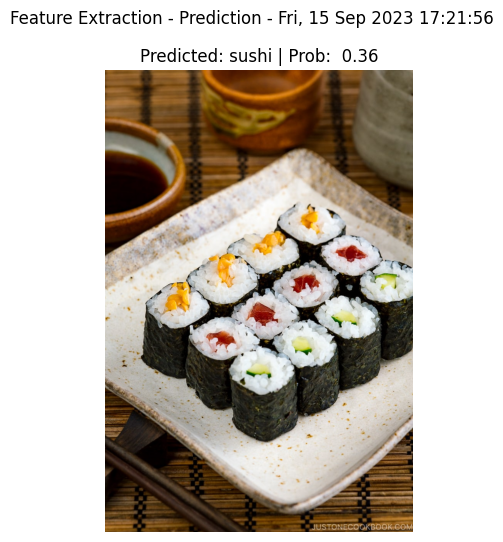

In [11]:
# create a feature extraction model
new_feature_extraction_model = create_model(feature_extraction=True, fine_tuning=False, dropout_rate=dropout_rate, class_names=class_names)
new_feature_extraction_model.to(device)

# loaded the trained weights
new_feature_extraction_model.load_state_dict(torch.load(FE_MODEL_FILE_PATH))

# load a test image
image_test_file_path = DATA_DIR.joinpath("sushi_test.jpg")
logging.info(f"Testing the feature extraction model with a test image: {image_test_file_path}")

# PIl image
pil_image = Image.open(fp=str(image_test_file_path))

# tensor image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.484, 0.465, 0.406], std=[0.229, 0.224, 0.225])
])

# transformed image
transformed_image = transform(pil_image)

# convert to a batch of images
transformed_image_t = torch.unsqueeze(transformed_image, dim=0)
logging.info(f"Reshape the image: {transformed_image_t.shape}")

# predict with cpu
new_feature_extraction_model.eval()
with torch.inference_mode():
    y_logits = new_feature_extraction_model(transformed_image_t.to(device))
    y_predicted_label_id = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().item()
    y_predicted_label_probs = torch.max(torch.softmax(y_logits, dim=1)).cpu().item()
    y_predicted_label = class_names[int(y_predicted_label_id)]
    logging.info(f"Predicted: {y_predicted_label}")
    logging.info(f"Prob: {y_predicted_label_probs: .2f}")

# plot image
plt.figure(figsize=(6, 6))
plt.suptitle(f"Feature Extraction - Prediction - {now_str}")
plt.title(f"Predicted: {y_predicted_label} | Prob: {y_predicted_label_probs: .2f}")
plt.imshow(pil_image)
plt.axis(False)
plt.savefig(FE_PREDICTION_FILE_PATH, bbox_inches="tight")
logging.info(f"Feature extraction prediction's result is saved in this path: {FE_PREDICTION_FILE_PATH}")



In [12]:
# display history curves
def display_history_curves_feature_extraction(history_dict: dict, name: str, filepath: Path):

    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Transfer learning - {name} - {now_str}")

    accuracy = history_dict["accuracy"]
    loss = history_dict["loss"]
    val_accuracy = history_dict["val_accuracy"]
    val_loss = history_dict["val_loss"]

    epochs = list(range(len(accuracy)))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, c ="r", label="Training dataset")
    plt.plot(epochs, val_accuracy, c ="g", label="Testing dataset")
    plt.xlabel("Epochs")
    plt.xlabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, c ="r", label="Training dataset")
    plt.plot(epochs, val_loss, c ="g", label="Testing dataset")
    plt.xlabel("Epochs")
    plt.xlabel("Loss")
    plt.legend()

    plt.savefig(filepath, bbox_inches="tight")
    logging.info(f"History curves of the {name} model is saved in {filepath}")
    # plt.show()

# display history curves for fine tuning
def display_history_curves_fine_tuning(fe_history_dict: dict, ft_history_dict: dict, name: str, start_fine_tuning: int, filepath: Path):

    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Transfer learning - {name} - {now_str}")

    accuracy = fe_history_dict["accuracy"] + ft_history_dict["accuracy"]
    loss = fe_history_dict["loss"] + ft_history_dict["loss"]
    val_accuracy = fe_history_dict["val_accuracy"] + ft_history_dict["val_accuracy"]
    val_loss = fe_history_dict["val_loss"] + ft_history_dict["val_loss"]

    epochs = list(range(len(accuracy)))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, c ="r", label="Training dataset")
    plt.plot(epochs, val_accuracy, c ="g", label="Testing dataset")
    plt.plot([start_fine_tuning, start_fine_tuning], plt.ylim(), c="b", label="Start fine-tuning")
    plt.xlabel("Epochs")
    plt.xlabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, c ="r", label="Training dataset")
    plt.plot(epochs, val_loss, c ="g", label="Testing dataset")
    plt.plot([start_fine_tuning, start_fine_tuning], plt.ylim(), c="b", label="Start fine-tuning")
    plt.xlabel("Epochs")
    plt.xlabel("Loss")
    plt.legend()

    plt.savefig(filepath, bbox_inches="tight")
    logging.info(f"History curves of the {name} model is saved in {filepath}")
    # plt.show()


[Fri, 15 Sep 2023 17:24:58.730] INFO - History curves of the Feature Extraction model is saved in ../../logs/practice/06_transfer_learning_20230915/efficientnet_b0_bs_16/fe_history_curves_efficientnet_b0_bs_16_20230915_172156.png


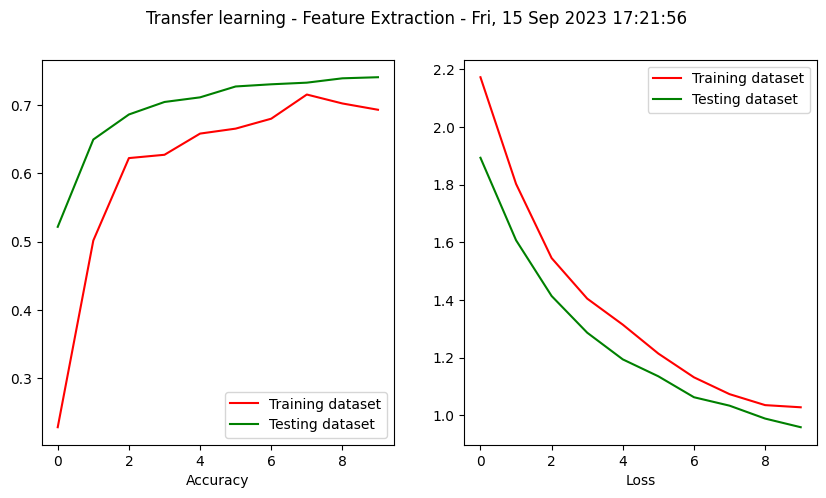

In [13]:
display_history_curves_feature_extraction(history_dict=feature_extraction_history_dict, name="Feature Extraction", filepath=FE_HISTORY_CURVES_FILE_PATH)

In [14]:
logging.info(f"Start training fine-tuning model...")

# create an instance of the feature extraction model
new_feature_extraction_model_0 = create_model(feature_extraction=True, fine_tuning=False, dropout_rate=dropout_rate, class_names=class_names)

# load the trained feature extraction model
new_feature_extraction_model_0.load_state_dict(torch.load(FE_MODEL_FILE_PATH))

# create an fine-tuning model
fine_tuning_model_0 = create_model(model_0=new_feature_extraction_model_0, feature_extraction=False, fine_tuning=True, dropout_rate=dropout_rate, class_names=class_names)

# learning rate
fine_tuning_lr = 0.0001 # 10x lower
logging.info(f"Fine-tuning (learning rate): {fine_tuning_lr}")

# optimizer 
optimizer = torch.optim.Adam(params=fine_tuning_model_0.parameters(), lr=feature_extraction_lr)
logging.info(f"Fine-tuning (optimizer): torch.optim.Adam()")

# loss function
loss_fn = torch.nn.CrossEntropyLoss()
logging.info(f"Fine-tuning (loss function): torch.nn.CrossEntropyLoss()")

# fine tuning epochs
fine_tuning_epochs = feature_extraction_epochs + 10
logging.info(f"Fine-tuning (epochs): {fine_tuning_epochs}")

# init wandb
wandb.init(project="pytorch-deep-learning", name=f"tadac/{project_name}_fine_tuning", config={
    "batch_size": batch_size,
    "architecture": model_name,
    "learing_rate": fine_tuning_lr,
    "dataset": "food10",
    "epochs": fine_tuning_epochs,
})

# add logs from the feature history dict
for i in range(len(feature_extraction_history_dict["accuracy"])):
    # wandb dict
    fe_wantdb_dict = {
        "accuracy": feature_extraction_history_dict["accuracy"][i], 
        "loss" : feature_extraction_history_dict["loss"][i],
        "val_accuracy": feature_extraction_history_dict["val_accuracy"][i],
        "val_loss": feature_extraction_history_dict["val_loss"][i]
    }

    # wandb logging
    wandb.log(fe_wantdb_dict)



# data parallel
if use_data_parallel and num_gpus > 1:
    try:
        fine_tuning_model_0 = torch.nn.DataParallel(module=fine_tuning_model_0, device_ids=list(range(num_gpus)))
        is_running_data_parallel = True
        logging.info(f"Running {num_gpus} GPUs with DataParallel for this fine tuning model...")
    except Exception as error:
        is_running_data_parallel = False
        logging.error(f"Caught this error {error} during using DataParallel")

# running data parallel ?
logging.info("Running multiple GPUs with DataParallel for this model" if is_running_data_parallel else "Not running multiple GPUs with DataParallel for this model")

# send to device
fine_tuning_model_0.to(device)

# fine tuning history dict
fine_tuning_history_dict = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": [],
}


## Training loop
for epoch in tqdm(range(feature_extraction_epochs, fine_tuning_epochs)):

    # timer
    start_timer = timer()

    ## training mode
    accumulated_train_acc = 0.0
    accumulated_train_batches = 0
    accumulated_train_loss = 0.0

    for inputs, outputs in train_full_data_dataloader:
        
        # train mode
        fine_tuning_model_0.train()

        # send data to device
        inputs, outputs = inputs.to(device), outputs.to(device)

        # forward pass
        y_logits = fine_tuning_model_0(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss.data

        # calculate acc
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_acc += (acc / len(y_logits))

        # zero gradient
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    # eval mode
    fine_tuning_model_0.eval()
    with torch.inference_mode():

        accumulated_test_acc = 0.0
        accumulated_test_batches = 0
        accumulated_test_loss = 0.0

        for inputs, outputs in test_full_data_dataloader:
            
            # send data to device
            inputs, outputs = inputs.to(device), outputs.to(device)

            # forward pass
            y_logits = fine_tuning_model_0(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss.data

            # calculate acc
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_acc += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1

    # timer
    end_timer = timer()
    duration = end_timer - start_timer

    # training
    accuracy = accumulated_train_acc / accumulated_train_batches
    loss = accumulated_train_loss.cpu().numpy() / accumulated_train_batches

    # test
    val_accuracy = accumulated_test_acc / accumulated_test_batches
    val_loss = accumulated_test_loss.cpu().numpy() / accumulated_test_batches

    # save history dict
    fine_tuning_history_dict["accuracy"].append(accuracy)
    fine_tuning_history_dict["loss"].append(loss)
    fine_tuning_history_dict["val_accuracy"].append(val_accuracy)
    fine_tuning_history_dict["val_loss"].append(val_loss)

    # wandb dict
    ft_wantdb_dict = {
        "accuracy": accuracy, 
        "loss" : loss,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss
    }

    # wandb logging
    wandb.log(ft_wantdb_dict)

    # print out
    logging.info(f"Epoch: {epoch + 1} / {fine_tuning_epochs} | "
                 f"{duration: .2f}s | "
                 f"accuracy: {accuracy: .2f} | "
                 f"loss: {loss: .3f} | "
                 f"val_accuracy: {val_accuracy: .2f} | "
                 f"val_loss: {val_loss: .3f}"
                 )


# save model 
if is_running_data_parallel:
    torch.save(fine_tuning_model_0.module.state_dict(), FT_MODEL_FILE_PATH)
else:
    torch.save(fine_tuning_model_0.state_dict(), FT_MODEL_FILE_PATH)
    
logging.info(f"The fine-tuning model is saved in this path: {FT_MODEL_FILE_PATH}")

# reset 
is_running_data_parallel = False

# finish wandb
wandb.finish()


[Fri, 15 Sep 2023 17:24:58.884] INFO - Start training fine-tuning model...
[Fri, 15 Sep 2023 17:24:59.023] INFO - Dropout rate: 0.5
[Fri, 15 Sep 2023 17:24:59.136] INFO - =========================================================================================================
Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4          

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

[Fri, 15 Sep 2023 17:24:59.398] INFO - =========================================================================================================
Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]   

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

[Fri, 15 Sep 2023 17:25:04.420] INFO - Not running multiple GPUs with DataParallel for this model
100%|██████████| 10/10 [08:32<00:00, 51.29s/it]
[Fri, 15 Sep 2023 17:33:37.361] INFO - The fine-tuning model is saved in this path: ../../models/practice/06_transfer_learning_20230915/efficientnet_b0_bs_16/ft_efficientnet_b0_bs_16_20230915_172156.h5


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▄▅▆▆▆▆▇▆▆▆▇▇▇██████
loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▄▅▅▅▅▅▅▅██████████
val_loss,█▇▆▅▅▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁
accuracy,0.8425
loss,0.47898
val_accuracy,0.87818
val_loss,0.3997


[Fri, 15 Sep 2023 17:33:43.754] INFO - History curves of the Fine-tuning model is saved in ../../logs/practice/06_transfer_learning_20230915/efficientnet_b0_bs_16/ft_history_curves_efficientnet_b0_bs_16_20230915_172156.png


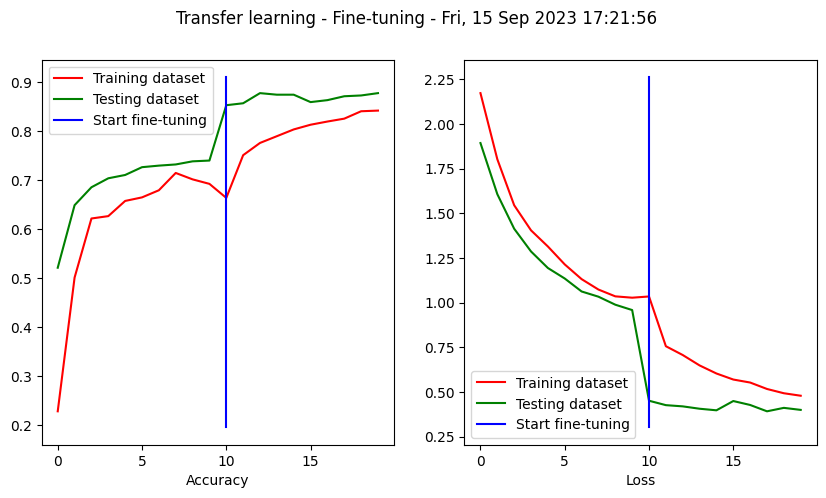

In [15]:
display_history_curves_fine_tuning(fe_history_dict=feature_extraction_history_dict, 
                                   ft_history_dict=fine_tuning_history_dict,
                                   start_fine_tuning= feature_extraction_epochs,
                                   name="Fine-tuning", filepath=FT_HISTORY_CURVES_FILE_PATH)

In [16]:
# gpu status
get_gpu_util()

# clear cache
torch.cuda.empty_cache()

[Fri, 15 Sep 2023 17:33:43.902] INFO - GPU status
[Fri, 15 Sep 2023 17:33:43.903] INFO - jason - [0] NVIDIA GeForce MX450 | 1641 / 2048 MB


[Fri, 15 Sep 2023 17:33:44.091] INFO - Dropout rate: 0.5
[Fri, 15 Sep 2023 17:33:44.202] INFO - =========================================================================================================
Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential:

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

[Fri, 15 Sep 2023 17:33:44.610] INFO - Fine-tuning prediction's result is saved in this path: ../../logs/practice/06_transfer_learning_20230915/efficientnet_b0_bs_16/ft_prediction_efficientnet_b0_bs_16_20230915_172156.png


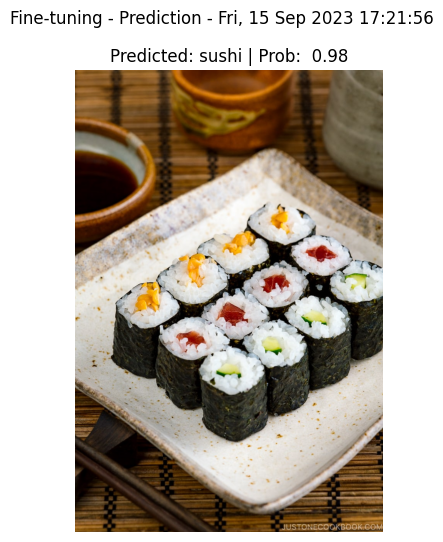

In [17]:
# create an fine tuning model
new_fine_tuning_model = create_model(feature_extraction=True, fine_tuning=False, dropout_rate=dropout_rate, class_names=class_names)

# loaded the trained weights
new_fine_tuning_model.load_state_dict(torch.load(FT_MODEL_FILE_PATH))

# send model to device
new_fine_tuning_model.to(device)

# load a test image
image_test_file_path = DATA_DIR.joinpath("sushi_test.jpg")

# PIl image
pil_image = Image.open(fp=str(image_test_file_path))

# tensor image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.484, 0.465, 0.406], std=[0.229, 0.224, 0.225])
])

# transformed image
transformed_image = transform(pil_image)

# convert to a batch of images
transformed_image_t = torch.unsqueeze(transformed_image, dim=0)
logging.info(f"Reshape the image: {transformed_image_t.shape}")

# predict with cpu
new_fine_tuning_model.eval()
with torch.inference_mode():
    y_logits = new_fine_tuning_model(transformed_image_t.to(device))
    y_predicted_label_id = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).item()
    y_predicted_label_probs = torch.max(torch.softmax(y_logits, dim=1))
    y_predicted_label = class_names[int(y_predicted_label_id)]
    logging.info(f"Predicted: {y_predicted_label}")
    logging.info(f"Prob: {y_predicted_label_probs: .2f}")

# plot image
plt.figure(figsize=(6, 6))
plt.suptitle(f"Fine-tuning - Prediction - {now_str}")
plt.title(f"Predicted: {y_predicted_label} | Prob: {y_predicted_label_probs: .2f}")
plt.imshow(pil_image)
plt.axis(False)
plt.savefig(FT_PREDICTION_FILE_PATH, bbox_inches="tight")
logging.info(f"Fine-tuning prediction's result is saved in this path: {FT_PREDICTION_FILE_PATH}")

